<a href="https://colab.research.google.com/github/divyam63/Sarcasm_Model/blob/main/SarcasmDetectionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
import torch

In [ ]:
csv_path = "/content/file.csv"
df = pd.read_csv(csv_path)

# Get the actual column names from the DataFrame
columns_to_drop = [col for col in ["Unnamed: 2", "Unnamed: 3"] if col in df.columns]

# Drop only the columns that exist
df = df.drop(columns=columns_to_drop)
df_majority = df[df['label'] == 0]
df_minority = df[df['label'] == 1]
plt.figure(figsize=(8, 6))

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

        Unnamed: 0  Unnamed: 1  \
2              NaN         NaN   
4              NaN         NaN   
5              NaN         NaN   
6              NaN         NaN   
8              NaN         NaN   
...            ...         ...   
115748         NaN         NaN   
101071         NaN         NaN   
175076         NaN         NaN   
24232          NaN         NaN   
21742          NaN         NaN   

                                                     text  label  
2        Please Avail the Covid-19 Vaccine on control ...      0  
4       The Draconian Machinations of Evil Republicans...      0  
5        one of the first lawsuits against 🇨🇳 for the ...      0  
6        As u mentioned in last speech micro containme...      0  
8       Stay alert with Omnicron Varient, stay protect...      0  
...                                                   ...    ...  
115748  POTUS et. al has worked hard to ensure there i...      1  
101071   Great. This option is very Good in means of r.

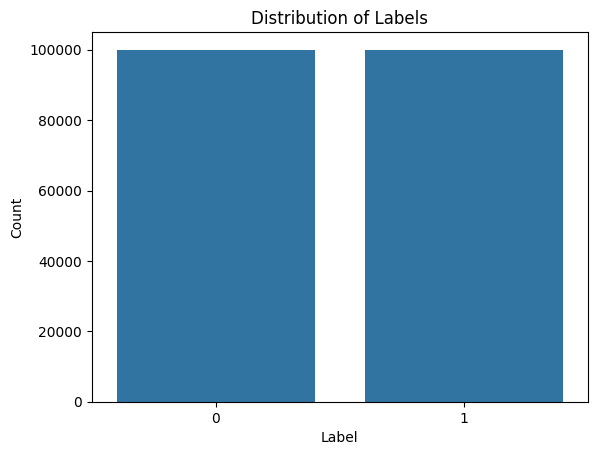

In [ ]:
df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Split data into features (X) and labels (y)
X = df_upsampled['text'].values
y = df_upsampled['label'].values
sns.countplot(x='label', data=df_upsampled)
print(df_upsampled)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Show the plot
plt.show()

In [ ]:
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
max_length = 128  # Set the maximum sequence length for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X_train_encoded = tokenizer.batch_encode_plus(
    X_train.tolist(),
    add_special_tokens=True,
    max_length=max_length,
    return_attention_mask=True,
    return_tensors='tf',
    pad_to_max_length=True,
    truncation=True
)
X_test_encoded = tokenizer.batch_encode_plus(
    X_test.tolist(),
    add_special_tokens=True,
    max_length=max_length,
    return_attention_mask=True,
    return_tensors='tf',
    pad_to_max_length=True,
    truncation=True
)

# Define class weights for handling imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
embedding_dim = 100
lstm_units = 128

input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=len(tokenizer.get_vocab()), output_dim=embedding_dim, input_length=max_length)(input_layer)
bi_lstm_layer = Bidirectional(LSTM(lstm_units))(embedding_layer)
dropout_layer = Dropout(0.5)(bi_lstm_layer)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

bi_lstm_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the Bi-LSTM model
bi_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Bi-LSTM model
bi_lstm_model.fit(X_train_encoded['input_ids'], y_train, epochs=1, batch_size=64, class_weight=class_weight_dict)

# Evaluate the Bi-LSTM model
bi_lstm_loss, bi_lstm_accuracy = bi_lstm_model.evaluate(X_test_encoded['input_ids'], y_test)

print("Bi-LSTM Model - Loss:", bi_lstm_loss)
print("Bi-LSTM Model - Accuracy:", bi_lstm_accuracy)

2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1319s 600ms/step - accuracy: 0.6913 - loss: 0.5674
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 224s 119ms/step - accuracy: 0.7886 - loss: 0.4533
Bi-LSTM Model - Loss: 0.4534052610397339
Bi-LSTM Model - Accuracy: 0.7875499725341797


In [ ]:
import joblib

# Load the pre-trained model
loaded_model = joblib.load('bi_lstm_model.joblib')  # Replace 'bi_lstm_model.joblib' with the actual file name

# Now you can use loaded_model for predictions
# For example:


# Save the model
joblib.dump(bi_lstm_model, 'bi_lstm_model.joblib')

# Load the model
loaded_model = joblib.load('bi_lstm_model.joblib')


# Save the model using joblib
joblib.dump(bi_lstm_model, 'bi_lstm_model.joblib')
loaded_model = joblib.load('bi_lstm_model.joblib')  # Replace with the actual file name


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 232s 124ms/step
Testing Accuracy: 0.78755
Testing F1 Score: 0.7961947397873531
              precision    recall  f1-score   support

           0       0.81      0.75      0.78     29851
           1       0.77      0.83      0.80     30149

    accuracy                           0.79     60000
   macro avg       0.79      0.79      0.79     60000
weighted avg       0.79      0.79      0.79     60000

The Accuracy is 0.78755


<Axes: >

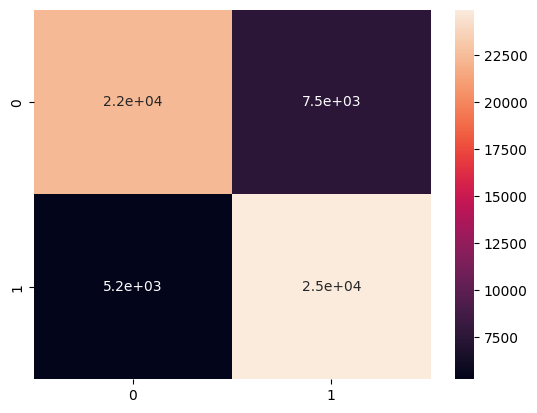

In [ ]:
y_pred = loaded_model.predict(X_test_encoded['input_ids'])
y_pred_labels = (y_pred > 0.5).astype(int)

# Print some evaluation metrics (e.g., accuracy)
accuracy = accuracy_score(y_test, y_pred_labels)
print("Testing Accuracy:", accuracy)
f1 = f1_score(y_test, y_pred_labels)
print("Testing F1 Score:", f1)
cm=confusion_matrix(y_test,y_pred_labels)
print(classification_report(y_test,y_pred_labels))
print("The Accuracy is",accuracy_score(y_test,y_pred_labels))
sns.heatmap(cm,annot=True)

NameError: name 'loaded_bi_lstm_model' is not defined

In [ ]:
def preprocess_input(input_text):
    blob = TextBlob(input_text)
    sentiment_scores = [sentence.sentiment.polarity for sentence in blob.sentences]
    return sentiment_scores

In [ ]:
def classify_sentiment_shifts(sentiment_scores): # Sentimental Scores:
    positive_count=0
    negative_count=0
    flag=0;
    prev_sentiment = sentiment_scores[0]
    for sentiment in sentiment_scores[1:]:

        if prev_sentiment > 0 and sentiment>=0 :
            positive_count=positive_count+1
        elif prev_sentiment >0 and sentiment<= 0:
            negative_count=negative_count+1
            prev_sentiment=sentiment
            flag=1;
            continue
        elif prev_sentiment< 0 and sentiment <=0 and flag==1:
            negative_count=negative_count+1
        elif prev_sentiment < 0 and sentiment >=0 and flag==1:
            positive_count=positive_count+1
        prev_sentiment=sentiment
    if positive_count > negative_count or negative_count > positive_count:
        return 0
    elif positive_count ==0 and negative_count==0:
        return 0
    else:
        return 1

In [ ]:
def classify_using_lstm(input_text):
    sentiment_scores = preprocess_input(input_text)
    classification = classify_sentiment_shifts(sentiment_scores)

    return classification

def classify_sarcasm_with_lstm(input_text):
    input_encoded = tokenizer.encode_plus(
        input_text,
        add_special_tokens=True,
        max_length=max_length,
        return_attention_mask=True,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

    prediction = bi_lstm_model.predict(input_encoded['input_ids'])
    prediction_label = 1 if prediction > 0.7 else 0

    return prediction_label

In [ ]:
!python -m textblob.download_corpora

user_input = input("Enter a text: ")
lstm_classification = classify_using_lstm(user_input)
print(lstm_classification)
if lstm_classification == 0:
    print("Non-sarcastic (From Sentimental Score)")
elif lstm_classification == 1:
    print("Sarcastic (From Sentimental Score)")
lstm_sarcasm_classification = classify_sarcasm_with_lstm(user_input)
if lstm_sarcasm_classification == 1:
    print("Sarcastic (Using BiLSTM)")
else:
    print("Non-sarcastic (Using BiLSTM)")
print("User Input:", user_input)

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.
Enter a text: hurrah we lost match
0
Non-sarcastic (From Sentimental Score)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Non-sarcastic (Using BiLSTM)
User Input: hurrah we lost match
